#### Zastosowane biblioteki

In [ ]:
import numpy as np
import pandas as pd
import os
from fastai.tabular.all import df_shrink

from sklearn.model_selection import train_test_split, learning_curve
from sklearn.feature_selection import RFE
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.decomposition import PCA

import jax
import jax.numpy as jnp
from jax.example_libraries.optimizers import adam
from jax.example_libraries import stax

from keras.models import Sequential
from keras.layers import Dense

from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

# Obróbka danych

## Pierwszy etap

### Czytanie ścieżek do plików i danych

In [ ]:
def read_paths(dir_path):
  dspaths = []
  for dirname, _, filenames in os.walk(dir_path):
      for filename in filenames:
          if filename.endswith('.csv'):
              pds = os.path.join(dirname, filename)
              dspaths.append(pds)
              print(pds)
  return dspaths

def read_files(dspaths):
  individual_dfs = [pd.read_csv(dsp, sep=',', encoding='utf-8') for dsp in dspaths]
  [i.shape for i in individual_dfs]
  return individual_dfs

dspaths = read_paths('../IDS2017/Raw')
individual_dfs = read_files(dspaths)

individual_dfs[1].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286467 entries, 0 to 286466
Data columns (total 79 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0    Destination Port             286467 non-null  int64  
 1    Flow Duration                286467 non-null  int64  
 2    Total Fwd Packets            286467 non-null  int64  
 3    Total Backward Packets       286467 non-null  int64  
 4   Total Length of Fwd Packets   286467 non-null  int64  
 5    Total Length of Bwd Packets  286467 non-null  int64  
 6    Fwd Packet Length Max        286467 non-null  int64  
 7    Fwd Packet Length Min        286467 non-null  int64  
 8    Fwd Packet Length Mean       286467 non-null  float64
 9    Fwd Packet Length Std        286467 non-null  float64
 10  Bwd Packet Length Max         286467 non-null  int64  
 11   Bwd Packet Length Min        286467 non-null  int64  
 12   Bwd Packet Length Mean       286467 non-nul

### Downsizing

In [ ]:
individual_dfs[0].dtypes

 Destination Port                int64
 Flow Duration                   int64
 Total Fwd Packets               int64
 Total Backward Packets          int64
Total Length of Fwd Packets      int64
                                ...   
Idle Mean                      float64
 Idle Std                      float64
 Idle Max                        int64
 Idle Min                        int64
 Label                          object
Length: 79, dtype: object

In [ ]:
individual_dfs = [df_shrink(df) for df in individual_dfs]
individual_dfs[0].dtypes

 Destination Port                 int32
 Flow Duration                    int32
 Total Fwd Packets                int16
 Total Backward Packets           int16
Total Length of Fwd Packets       int32
                                 ...   
Idle Mean                       float32
 Idle Std                       float32
 Idle Max                         int32
 Idle Min                         int32
 Label                         category
Length: 79, dtype: object

### Usuwanie niezdefiniowanych wartości i zduplikowanych wierszy

In [ ]:
def drop_nan(individual_dfs):
  for df in individual_dfs:
      df.replace([np.inf, -np.inf], np.nan, inplace=True)
      df.dropna(inplace=True)
  [i.shape for i in individual_dfs]
  return individual_dfs

individual_dfs = drop_nan(individual_dfs)

def drop_dupes(individual_dfs):
  for df in individual_dfs:
      print(df.duplicated().sum(), "fully duplicate rows to remove")
      df.drop_duplicates(inplace=True)
      df.reset_index(inplace=True, drop=True)
  [i.shape for i in individual_dfs]
  return individual_dfs

individual_dfs = drop_dupes(individual_dfs)

2629 fully duplicate rows to remove
72319 fully duplicate rows to remove
6867 fully duplicate rows to remove
26831 fully duplicate rows to remove
35605 fully duplicate rows to remove
6052 fully duplicate rows to remove
24019 fully duplicate rows to remove
80914 fully duplicate rows to remove


### Zapisywanie danych w odpowiednich formatach

In [ ]:
def convert(individual_dfs):
  for i, df in enumerate(individual_dfs):
        csv_path = f"../IDS2017/Clean/{dspaths[i].split('/')[-1].replace('.pcap_ISCX', '')[4:]}"
        df.to_csv(csv_path, index=False)

convert(individual_dfs)

combined_df = pd.concat(individual_dfs, ignore_index=True)
combined_df.to_csv("../IDS2017/Clean/Combined.csv", index=False)

def convert(individual_dfs):
  for i, df in enumerate(individual_dfs):
      df.to_parquet(f"../IDS2017/Clean/{dspaths[i].split('/')[-1].replace('.pcap_ISCX.csv', '.parquet')[4:]}")

convert(individual_dfs)

def convert_to_single_parquet(individual_dfs, output_path):
    combined_df = pd.concat(individual_dfs, ignore_index=True)
    combined_df.to_parquet(output_path)

convert_to_single_parquet(individual_dfs, "../IDS2017/Clean/Combined.parquet")

## Drugi etap


### Zamienianie wartośći z kolumny Label na BENINGN/ATTACK


In [ ]:
label_map = {'BENIGN': 'BENIGN', 'DDoS': 'ATTACK', 'DoS Hulk': 'ATTACK', 'DoS GoldenEye': 'ATTACK', 'DoS slowloris': 'ATTACK',
             'FTP-Patator': 'ATTACK', 'SSH-Patator':  'ATTACK', 'DoS Slowhttptest': 'ATTACK', 'PortScan': 'ATTACK',
             'Web Attack � Brute Force' : 'ATTACK', 'Bot': 'ATTACK', 'Web Attack � XSS': 'ATTACK', 'Infiltration': 'ATTACK',
             'Web Attack � Sql Injection': 'ATTACK', 'Heartbleed': 'ATTACK'}
combined01['Label'] = combined01['Label'].map(label_map).fillna('ATTACK')

print(combined01['Label'].value_counts())

Label
BENIGN    1886548
ATTACK     316445
Name: count, dtype: int64


### Metoda bez iteracji 

#### Uzyskanie ważności cech za pomocą Random Forest

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

importances = rf.feature_importances_
feature_names = X.columns

feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

print(feature_importances.head(10))

                        Feature  Importance
6         Fwd Packet Length Max    0.087524
8        Fwd Packet Length Mean    0.081587
66       Init_Win_bytes_forward    0.078397
11        Bwd Packet Length Min    0.061249
53         Avg Fwd Segment Size    0.061098
0              Destination Port    0.060444
4   Total Length of Fwd Packets    0.049032
63            Subflow Fwd Bytes    0.048209
62          Subflow Fwd Packets    0.046814
68             act_data_pkt_fwd    0.037963


In [ ]:
mean_importance = feature_importances['Importance'].mean()

important_features = feature_importances[feature_importances['Importance'] > mean_importance]
important_feature_names = important_features['Feature'].tolist()

X_important = X[important_feature_names]

print(important_feature_names)

[' Fwd Packet Length Max', ' Fwd Packet Length Mean', 'Init_Win_bytes_forward', ' Bwd Packet Length Min', ' Avg Fwd Segment Size', ' Destination Port', 'Total Length of Fwd Packets', ' Subflow Fwd Bytes', 'Subflow Fwd Packets', ' act_data_pkt_fwd', ' Fwd IAT Std', ' Fwd Header Length.1', 'Fwd IAT Total', ' Fwd Header Length', ' Bwd Header Length', ' Fwd IAT Mean', ' Fwd IAT Max', ' Average Packet Size', 'Bwd Packet Length Max', ' Fwd Packet Length Std']


### Metoda Recursive Feature Elimination
Bardziej wszechstronna metoda, która daje prezycyjne wyniki, ale wymaga więcej zasobów

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

selector = RFE(rf, n_features_to_select=10, step=1) 
selector = selector.fit(X_train, y_train)


selected_features = X.columns[selector.support_]
print(selected_features)

Index(['Total Length of Fwd Packets', ' Total Length of Bwd Packets',
       'Bwd Packet Length Max', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', ' Average Packet Size',
       ' Avg Bwd Segment Size', ' Fwd Header Length.1', ' Subflow Fwd Bytes',
       ' Subflow Bwd Bytes'],
      dtype='object')


### Zostawiamy tylko wybrane kolumny (i Label) w danych 

In [ ]:
selected_features = [' Label',' Destination Port', 'Total Length of Fwd Packets',
                     ' Fwd Packet Length Max', ' Fwd Packet Length Mean',
                     ' Fwd Header Length', ' Avg Fwd Segment Size',
                     ' Subflow Fwd Bytes', 'Init_Win_bytes_forward', ' act_data_pkt_fwd']

'''selected_features = [' Label', 'Total Length of Fwd Packets', ' Total Length of Bwd Packets',
       'Bwd Packet Length Max', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', ' Average Packet Size',
       ' Avg Bwd Segment Size', ' Fwd Header Length.1', ' Subflow Fwd Bytes',
       ' Subflow Bwd Bytes']'''

new_data = data[selected_features]
data.columns = data.columns.str.lstrip()
print(new_data.sample())

#new_data.to_csv("./IDS2017/Final/DDoS_Attacks.csv", index=False)
new_data.to_parquet("../IDS2017/Final/Wednesday.parquet", index=False)

         Label  Total Length of Fwd Packets   Total Length of Bwd Packets  \
487728  BENIGN                           64                            96   

        Bwd Packet Length Max   Bwd Packet Length Mean  \
487728                     48                     48.0   

         Bwd Packet Length Std   Average Packet Size   Avg Bwd Segment Size  \
487728                     0.0                  48.0                   48.0   

         Fwd Header Length.1   Subflow Fwd Bytes   Subflow Bwd Bytes  
487728                    40                  64                  96  


# Statystyki dotyczące danych

### Wykres słupkowy każdego typu ataku

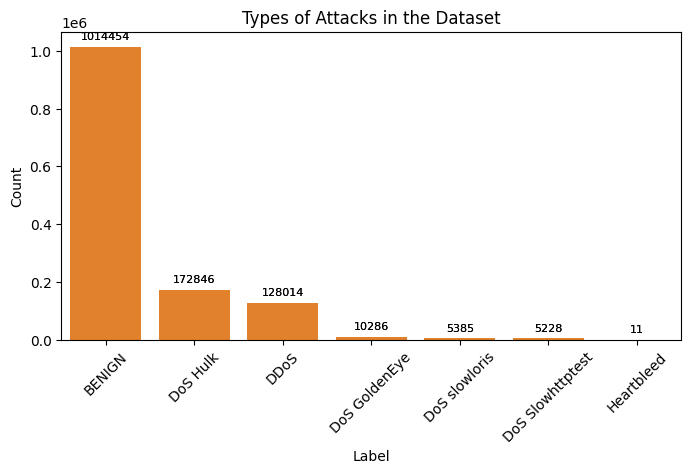

Label
BENIGN              1014454
DoS Hulk             172846
DDoS                 128014
DoS GoldenEye         10286
DoS slowloris          5385
DoS Slowhttptest       5228
Heartbleed               11
Name: count, dtype: int64
Benign: 1014454
Malicious: 321770


In [ ]:
label_counts = df['Label'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(8, 4))
sns.countplot(x='Label', data=df, order=label_counts.index)
ax = sns.countplot(x='Label', data=df, order=label_counts.index)

plt.title('Types of Attacks in the Dataset')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45)

for p in ax.patches:
    ax.annotate(
        f'{int(p.get_height())}', 
        (p.get_x() + p.get_width() / 2., p.get_height()), 
        ha = 'center', 
        va = 'baseline', 
        fontsize = 8, 
        color = 'black', 
        xytext = (0, 5), 
        textcoords = 'offset points'
    )

plt.show()
print(label_counts)

print('Benign:', label_counts.iloc[0])
print('Malicious:', label_counts.iloc[1:].sum())

### Heatmapa dla kolum w zbiorze danych

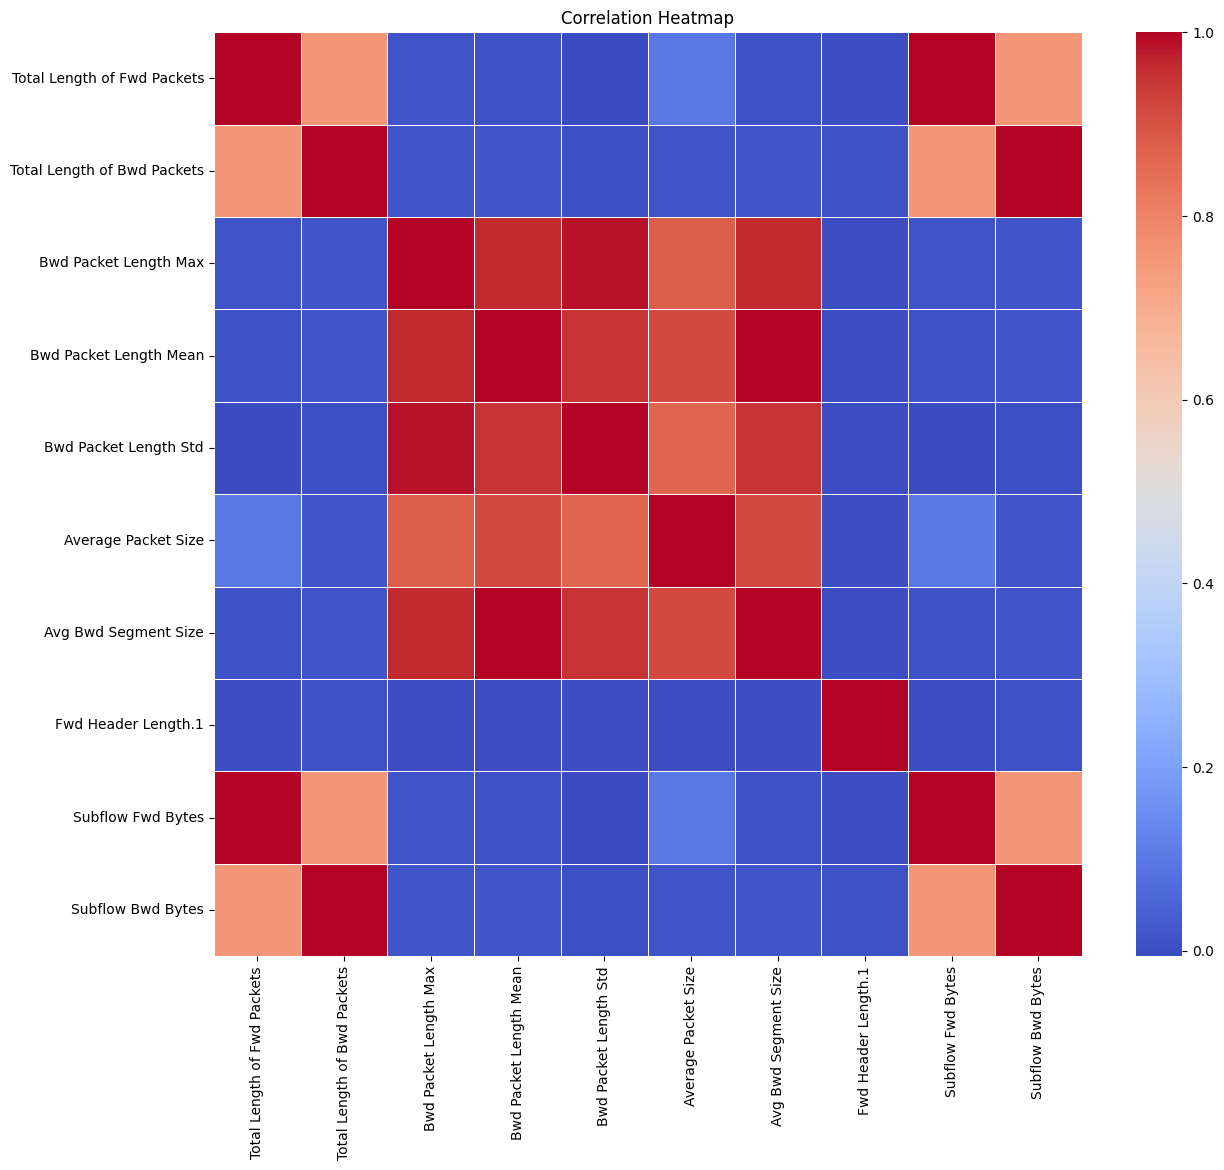

In [ ]:
X = df.drop('Label', axis=1)
plt.figure(figsize=(14, 12))
correlation_matrix = X.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

# Uczenie nadzorowane

## Random Forest

### Środa

In [ ]:
data = pd.read_parquet('./IDS2017/Final/Wednesday.parquet')

X = data.drop(columns=['Label'])
y = data['Label']

X_train, X_val, Y_train, Y_val = train_test_split(X,
                                                  y, 
                                                  test_size = 0.3, 
                                                  random_state=2022)
print(X_train.shape, X_val.shape)

model = RandomForestClassifier()
model.fit(X_train, Y_train)
print('Training Accuracy : ', 
      metrics.accuracy_score(Y_train,
                             model.predict(X_train))*100)
print('Validation Accuracy : ', 
      metrics.accuracy_score(Y_val, 
                             model.predict(X_val))*100)

class_labels = y.unique()
confusion_matrix = metrics.confusion_matrix(Y_val, model.predict(X_val))
confusion_df = pd.DataFrame(confusion_matrix, index=class_labels, columns=class_labels)

print("Confusion Matrix:")
print(confusion_df)

classification_report = metrics.classification_report(Y_val, model.predict(X_val), target_names=class_labels)
print("Classification Report:")
print(classification_report)

(427344, 10) (183148, 10)
Training Accuracy :  98.95189823654947
Validation Accuracy :  98.94839146482626
Confusion Matrix:
                  BENIGN  DoS slowloris  DoS Slowhttptest  DoS Hulk  \
BENIGN            124561              2               291        51   
DoS slowloris        748           2339                 0         1   
DoS Slowhttptest     787              0             51253         1   
DoS Hulk              15              0                 1      1495   
DoS GoldenEye         13              0                 0         3   
Heartbleed             0              0                 0         0   

                  DoS GoldenEye  Heartbleed  
BENIGN                        2           0  
DoS slowloris                 0           0  
DoS Slowhttptest              0           0  
DoS Hulk                     11           0  
DoS GoldenEye              1572           0  
Heartbleed                    0           2  
Classification Report:
                  precision    re

### Piątek

In [ ]:
data2 = pd.read_parquet('./IDS2017/Final/Friday.parquet')


X = data2.drop(columns=['Label'])
y = data2['Label']


X_train, X_val, Y_train, Y_val = train_test_split(X, y, test_size=0.3, random_state=2022)
print(X_train.shape, X_val.shape)

model2 = RandomForestClassifier()
model2.fit(X_train, Y_train)

print('Training Accuracy : ', metrics.accuracy_score(Y_train, model2.predict(X_train)) * 100)
print('Validation Accuracy : ', metrics.accuracy_score(Y_val, model2.predict(X_val)) * 100)


confusion_matrix = metrics.confusion_matrix(Y_val, model2.predict(X_val))
class_labels = sorted(Y_val.unique())

confusion_df = pd.DataFrame(confusion_matrix, index=class_labels, columns=class_labels)

print("Confusion Matrix:")
print(confusion_df)

classification_report = metrics.classification_report(Y_val, model2.predict(X_val), target_names=class_labels)
print("Classification Report:")
print(classification_report)

(156157, 10) (66925, 10)
Training Accuracy :  99.92059273679695
Validation Accuracy :  99.90885319387374
Confusion Matrix:
        BENIGN   DDoS
BENIGN   28523      5
DDoS        56  38341
Classification Report:
              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00     28528
        DDoS       1.00      1.00      1.00     38397

    accuracy                           1.00     66925
   macro avg       1.00      1.00      1.00     66925
weighted avg       1.00      1.00      1.00     66925



### Połączone DDoSy

In [ ]:
data3 = pd.read_parquet('./IDS2017/Final/Combined.parquet')


X = data3.drop(columns=['Label'])
y = data3['Label']
X_train, X_val, Y_train, Y_val = train_test_split(X,
                                                  y, 
                                                  test_size = 0.3, 
                                                  random_state=2022)
print(X_train.shape, X_val.shape)

model3 = RandomForestClassifier()
model3.fit(X_train, Y_train)
print('Training Accuracy : ', 
      metrics.accuracy_score(Y_train,
                             model3.predict(X_train))*100)
print('Validation Accuracy : ', 
      metrics.accuracy_score(Y_val, 
                             model3.predict(X_val))*100)


confusion_matrix = metrics.confusion_matrix(Y_val, model2.predict(X_val))
class_labels = sorted(Y_val.unique())

confusion_df = pd.DataFrame(confusion_matrix, index=class_labels, columns=class_labels)

print("Confusion Matrix:")
print(confusion_df)

classification_report = metrics.classification_report(Y_val, model2.predict(X_val), target_names=class_labels, zero_division=0)
print("Classification Report:")
print(classification_report)

(935356, 10) (400868, 10)
Training Accuracy :  99.22018995975864
Validation Accuracy :  99.20422682778371
Confusion Matrix:
                  BENIGN   DDoS  DoS GoldenEye  DoS Hulk  DoS Slowhttptest  \
BENIGN            304117    348              0         0                 0   
DDoS                  53  38420              0         0                 0   
DoS GoldenEye       2651    388              0         0                 0   
DoS Hulk           47654   4112              0         0                 0   
DoS Slowhttptest    1481      0              0         0                 0   
DoS slowloris       1641      0              0         0                 0   
Heartbleed             3      0              0         0                 0   

                  DoS slowloris  Heartbleed  
BENIGN                        0           0  
DDoS                          0           0  
DoS GoldenEye                 0           0  
DoS Hulk                      0           0  
DoS Slowhttptest     

## Logistic Regression

### Środa

In [ ]:
data = pd.read_parquet('./IDS2017/Final/Wednesday.parquet')

X = data.drop(columns=['Label'])
y = data['Label']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_val, Y_train, Y_val = train_test_split(X_scaled, y, test_size=0.3, random_state=2022)

clf = LogisticRegression(random_state=0, max_iter=1000)

clf.fit(X_train, Y_train)

y_pred_train = clf.predict(X_train)
y_pred_val = clf.predict(X_val)

print('Training Accuracy : ', metrics.accuracy_score(Y_train, y_pred_train) * 100)
print('Validation Accuracy : ', metrics.accuracy_score(Y_val, y_pred_val) * 100)

class_labels = y.unique()
confusion_matrix = metrics.confusion_matrix(Y_val, clf.predict(X_val))
confusion_df = pd.DataFrame(confusion_matrix, index=class_labels, columns=class_labels)

print("Confusion Matrix:")
print(confusion_df)

classification_report = metrics.classification_report(Y_val, clf.predict(X_val), target_names=class_labels)
print("Classification Report:")
print(classification_report)

Training Accuracy :  92.7999457111835
Validation Accuracy :  92.86970100683601
Confusion Matrix:
                  BENIGN  DoS slowloris  DoS Slowhttptest  DoS Hulk  \
BENIGN            124074             47               770         4   
DoS slowloris       1097            131              1860         0   
DoS Slowhttptest    5856            304             45878         0   
DoS Hulk            1455              0                62         5   
DoS GoldenEye       1588              0                 0         0   
Heartbleed             1              0                 0         0   

                  DoS GoldenEye  Heartbleed  
BENIGN                       12           0  
DoS slowloris                 0           0  
DoS Slowhttptest              0           3  
DoS Hulk                      0           0  
DoS GoldenEye                 0           0  
Heartbleed                    0           1  
Classification Report:
                  precision    recall  f1-score   support

 

### Piątek

In [ ]:
data2 = pd.read_parquet('./IDS2017/Final/Friday.parquet')

X = data2.drop(columns=['Label'])
y = data2['Label']

scaler2 = StandardScaler()
X_scaled = scaler2.fit_transform(X)

X_train, X_val, Y_train, Y_val = train_test_split(X_scaled, y, test_size=0.3, random_state=2022)

clf2 = LogisticRegression(random_state=0, max_iter=1000)

clf2.fit(X_train, Y_train)

y_pred_train = clf2.predict(X_train)
y_pred_val = clf2.predict(X_val)

print('Training Accuracy : ', metrics.accuracy_score(Y_train, y_pred_train) * 100)
print('Validation Accuracy : ', metrics.accuracy_score(Y_val, y_pred_val) * 100)

confusion_matrix = metrics.confusion_matrix(Y_val, clf2.predict(X_val))
class_labels = sorted(Y_val.unique())

confusion_df = pd.DataFrame(confusion_matrix, index=class_labels, columns=class_labels)

print("Confusion Matrix:")
print(confusion_df)

classification_report = metrics.classification_report(Y_val, clf2.predict(X_val), target_names=class_labels)
print("Classification Report:")
print(classification_report)

Training Accuracy :  97.67477602669109
Validation Accuracy :  97.6421367202092
Confusion Matrix:
        BENIGN   DDoS
BENIGN   27034   1494
DDoS        84  38313
Classification Report:
              precision    recall  f1-score   support

      BENIGN       1.00      0.95      0.97     28528
        DDoS       0.96      1.00      0.98     38397

    accuracy                           0.98     66925
   macro avg       0.98      0.97      0.98     66925
weighted avg       0.98      0.98      0.98     66925



In [ ]:
data3 = pd.read_parquet('./IDS2017/Final/Combined.parquet')

X = data3.drop(columns=['Label'])
y = data3['Label']

scaler3 = StandardScaler()
X_scaled = scaler3.fit_transform(X)

X_train, X_val, Y_train, Y_val = train_test_split(X_scaled, y, test_size=0.3, random_state=2022)

clf3 = LogisticRegression(random_state=0, max_iter=1000)

clf3.fit(X_train, Y_train)

y_pred_train = clf3.predict(X_train)
y_pred_val = clf3.predict(X_val)

print('Training Accuracy : ', metrics.accuracy_score(Y_train, y_pred_train) * 100)
print('Validation Accuracy : ', metrics.accuracy_score(Y_val, y_pred_val) * 100)

confusion_matrix = metrics.confusion_matrix(Y_val, clf3.predict(X_val))
class_labels = sorted(Y_val.unique())

confusion_df = pd.DataFrame(confusion_matrix, index=class_labels, columns=class_labels)

print("Confusion Matrix:")
print(confusion_df)

classification_report = metrics.classification_report(Y_val, clf3.predict(X_val), target_names=class_labels, zero_division=0)
print("Classification Report:")
print(classification_report)

Training Accuracy :  93.16570375343719
Validation Accuracy :  93.2279453585719
Confusion Matrix:
                  BENIGN   DDoS  DoS GoldenEye  DoS Hulk  DoS Slowhttptest  \
BENIGN            303471     61             16       917                 0   
DDoS               13970  24503              0         0                 0   
DoS GoldenEye       1127      6            101      1805                 0   
DoS Hulk            5861     12            248     45645                 0   
DoS Slowhttptest    1406     75              0         0                 0   
DoS slowloris       1641      0              0         0                 0   
Heartbleed             2      0              0         0                 0   

                  DoS slowloris  Heartbleed  
BENIGN                        0           0  
DDoS                          0           0  
DoS GoldenEye                 0           0  
DoS Hulk                      0           0  
DoS Slowhttptest              0           0  
Do

## K-NN

In [ ]:
df = pd.read_parquet('./IDS2017/Final/Combined.parquet')
print(df.columns)

label_encoder = LabelEncoder()
df['Label'] = label_encoder.fit_transform(df['Label'])

X = df.drop('Label', axis=1)
y = df['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Index(['Label', 'Total Length of Fwd Packets', 'Total Length of Bwd Packets',
       'Bwd Packet Length Max', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Average Packet Size', 'Avg Bwd Segment Size',
       'Fwd Header Length.1', 'Subflow Fwd Bytes', 'Subflow Bwd Bytes'],
      dtype='object')


In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)

knn.fit(X_train_scaled, y_train)

y_pred = knn.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9904207749443394

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    203048
           1       1.00      1.00      1.00     25437
           2       0.97      0.67      0.79      2072
           3       0.97      0.97      0.97     34590
           4       0.93      0.98      0.95      1054
           5       0.99      0.99      0.99      1042
           6       1.00      1.00      1.00         2

    accuracy                           0.99    267245
   macro avg       0.98      0.94      0.96    267245
weighted avg       0.99      0.99      0.99    267245



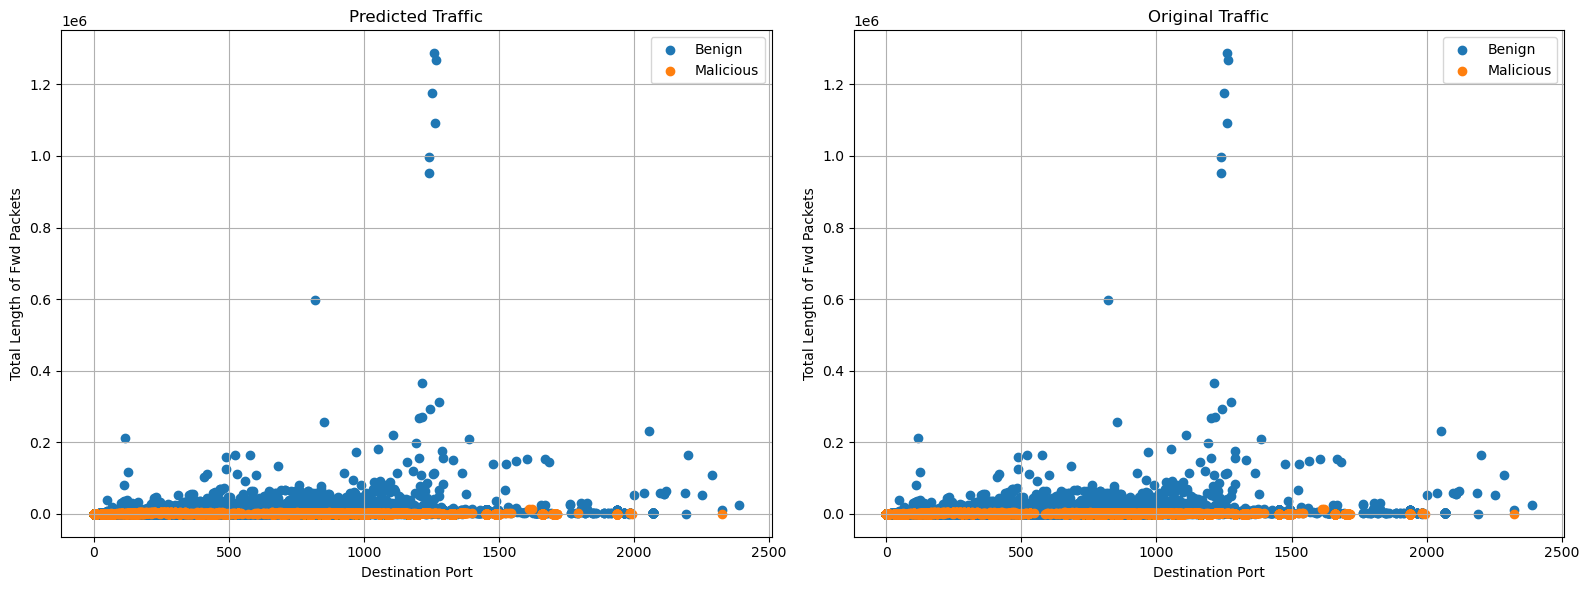

In [ ]:
df_test_original = X_test.copy()
df_test_original['Label'] = y_test
df_test_original['Original_Label'] = df.loc[df_test_original.index, 'Label']

df_test_original['Label'] = label_encoder.inverse_transform(df_test_original['Label'])
df_test_original['Original_Label'] = label_encoder.inverse_transform(df_test_original['Original_Label'])

benign_original = df_test_original[df_test_original['Original_Label'] == 'BENIGN']
malicious_original = df_test_original[df_test_original['Original_Label'] != 'BENIGN']

y_pred = knn.predict(X_test_scaled)
df_test = X_test.copy()
df_test['Label'] = y_test
df_test['Predicted_Label'] = y_pred

df_test['Label'] = label_encoder.inverse_transform(df_test['Label'])
df_test['Predicted_Label'] = label_encoder.inverse_transform(df_test['Predicted_Label'])

benign_data = df_test[df_test['Predicted_Label'] == 'BENIGN']
malicious_data = df_test[df_test['Predicted_Label'] != 'BENIGN']

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

axs[0].scatter(benign_data['Average Packet Size'], benign_data['Total Length of Fwd Packets'], label='Benign')
axs[0].scatter(malicious_data['Average Packet Size'], malicious_data['Total Length of Fwd Packets'], label='Malicious')
axs[0].set_title('Predicted Traffic')
axs[0].set_xlabel('Destination Port')
axs[0].set_ylabel('Total Length of Fwd Packets')
axs[0].legend()
axs[0].grid(True)

axs[1].scatter(benign_original['Average Packet Size'], benign_original['Total Length of Fwd Packets'], label='Benign')
axs[1].scatter(malicious_original['Average Packet Size'], malicious_original['Total Length of Fwd Packets'], label='Malicious')
axs[1].set_title('Original Traffic')
axs[1].set_xlabel('Destination Port')
axs[1].set_ylabel('Total Length of Fwd Packets')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

## Naive Bayes

### Środa

In [ ]:
data = pd.read_parquet('./IDS2017/Final/Wednesday.parquet')

X = data.drop(columns=['Label'])
y = data['Label']
X_train, X_val, Y_train, Y_val = train_test_split(X,
                                                  y, 
                                                  test_size = 0.3, 
                                                  random_state=2022)
print(X_train.shape, X_val.shape)

gnb = GaussianNB()
gnb.fit(X_train, Y_train)

print('Training Accuracy : ', 
      metrics.accuracy_score(Y_train,
                             gnb.predict(X_train))*100)
print('Validation Accuracy : ', 
      metrics.accuracy_score(Y_val, 
                             gnb.predict(X_val))*100)

class_labels = y.unique()
confusion_matrix = metrics.confusion_matrix(Y_val, gnb.predict(X_val))
confusion_df = pd.DataFrame(confusion_matrix, index=class_labels, columns=class_labels)

print("Confusion Matrix:")
print(confusion_df)

classification_report = metrics.classification_report(Y_val, gnb.predict(X_val), target_names=class_labels)
print("Classification Report:")
print(classification_report)

(427344, 10) (183148, 10)
Training Accuracy :  30.284501478902243
Validation Accuracy :  30.452420992858237
Confusion Matrix:
                  BENIGN  DoS slowloris  DoS Slowhttptest  DoS Hulk  \
BENIGN              8173          13853              1457     11205   
DoS slowloris         12            322              1878         0   
DoS Slowhttptest       0           1008             45630         0   
DoS Hulk               0             97                 0        96   
DoS GoldenEye          0              3                 0        35   
Heartbleed             0              0                 0         0   

                  DoS GoldenEye  Heartbleed  
BENIGN                    90211           8  
DoS slowloris               876           0  
DoS Slowhttptest           5403           0  
DoS Hulk                   1329           0  
DoS GoldenEye              1550           0  
Heartbleed                    0           2  
Classification Report:
                  precision    

### Piątek

In [ ]:
data2 = pd.read_parquet('./IDS2017/Final/Friday.parquet')

X = data2.drop(columns=['Label'])
y = data2['Label']
X_train, X_val, Y_train, Y_val = train_test_split(X,
                                                  y, 
                                                  test_size = 0.3, 
                                                  random_state=2022)
print(X_train.shape, X_val.shape)

gnb2 = GaussianNB()
gnb2.fit(X_train, Y_train)

print('Training Accuracy : ', 
      metrics.accuracy_score(Y_train,
                             gnb2.predict(X_train))*100)
print('Validation Accuracy : ', 
      metrics.accuracy_score(Y_val, 
                             gnb2.predict(X_val))*100)

confusion_matrix = metrics.confusion_matrix(Y_val, gnb2.predict(X_val))
class_labels = sorted(Y_val.unique())

confusion_df = pd.DataFrame(confusion_matrix, index=class_labels, columns=class_labels)

print("Confusion Matrix:")
print(confusion_df)

classification_report = metrics.classification_report(Y_val, gnb2.predict(X_val), target_names=class_labels)
print("Classification Report:")
print(classification_report)


(156157, 10) (66925, 10)
Training Accuracy :  82.39207976587664
Validation Accuracy :  82.33395592080687
Confusion Matrix:
        BENIGN   DDoS
BENIGN   16707  11821
DDoS         2  38395
Classification Report:
              precision    recall  f1-score   support

      BENIGN       1.00      0.59      0.74     28528
        DDoS       0.76      1.00      0.87     38397

    accuracy                           0.82     66925
   macro avg       0.88      0.79      0.80     66925
weighted avg       0.86      0.82      0.81     66925



### Połączone DDoSy

In [ ]:
data3 = pd.read_parquet('./IDS2017/Final/Combined.parquet')

X = data3.drop(columns=['Label'])
y = data3['Label']
X_train, X_val, Y_train, Y_val = train_test_split(X,
                                                  y, 
                                                  test_size = 0.3, 
                                                  random_state=2022)
print(X_train.shape, X_val.shape)

gnb3 = GaussianNB()
gnb3.fit(X_train, Y_train)

print('Training Accuracy : ', 
      metrics.accuracy_score(Y_train,
                             gnb3.predict(X_train))*100)
print('Validation Accuracy : ', 
      metrics.accuracy_score(Y_val, 
                             gnb3.predict(X_val))*100)

confusion_matrix = metrics.confusion_matrix(Y_val, gnb3.predict(X_val))
class_labels = sorted(Y_val.unique())

confusion_df = pd.DataFrame(confusion_matrix, index=class_labels, columns=class_labels)

print("Confusion Matrix:")
print(confusion_df)

classification_report = metrics.classification_report(Y_val, gnb3.predict(X_val), target_names=class_labels, zero_division=0)
print("Classification Report:")
print(classification_report)

(935356, 10) (400868, 10)
Training Accuracy :  21.74893837212783
Validation Accuracy :  21.914944570282486
Confusion Matrix:
                  BENIGN   DDoS  DoS GoldenEye  DoS Hulk  DoS Slowhttptest  \
BENIGN             20063    322          33847      3755             26461   
DDoS                   0  20380              0      4134                 0   
DoS GoldenEye          7      0            334      1829                 0   
DoS Hulk               0     13            989     45407                 0   
DoS Slowhttptest       1     76              5         0                62   
DoS slowloris          0      0              2         0                37   
Heartbleed             1      0              0         0                 0   

                  DoS slowloris  Heartbleed  
BENIGN                   220017           0  
DDoS                      13959           0  
DoS GoldenEye               869           0  
DoS Hulk                   5357           0  
DoS Slowhttptest    

## MLP

### Tune model

In [ ]:
df = pd.read_parquet('./IDS2017/Final/Combined.parquet')

df['Label'] = df['Label'].apply(lambda x: 1 if x == 'BENIGN' else 0).astype("int")  # BENIGN -> 1, non-BENIGN -> 0
df['Bwd Packet Length Max'] = df['Bwd Packet Length Max'].astype('int')

X = df.drop('Label', axis=1)
y = df['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units_1', min_value=8, max_value=64, step=8), 
                    input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(units=hp.Int('units_2', min_value=4, max_value=32, step=4), 
                    activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=2,
    directory='my_dir',
    project_name='network_anomaly_detection'
)

tuner.search(X_train, y_train, epochs=10, validation_split=0.2, batch_size=128)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

best_model.fit(X_train, y_train, epochs=10, batch_size=128, validation_split=0.3)

loss, accuracy = best_model.evaluate(X_test, y_test)
print('Test accuracy: %.2f' % (accuracy * 100))

### Run model on preset parameters

Epoch 1/8


c:\Users\delve\WebstormProjects\ids2018-anomaly-detection\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7308/7308 ━━━━━━━━━━━━━━━━━━━━ 7s 869us/step - accuracy: 0.9275 - loss: 0.2134 - val_accuracy: 0.9413 - val_loss: 0.1476
Epoch 2/8
7308/7308 ━━━━━━━━━━━━━━━━━━━━ 6s 861us/step - accuracy: 0.9411 - loss: 0.1450 - val_accuracy: 0.9417 - val_loss: 0.1356
Epoch 3/8
7308/7308 ━━━━━━━━━━━━━━━━━━━━ 6s 850us/step - accuracy: 0.9409 - loss: 0.1375 - val_accuracy: 0.9422 - val_loss: 0.1419
Epoch 4/8
7308/7308 ━━━━━━━━━━━━━━━━━━━━ 6s 803us/step - accuracy: 0.9412 - loss: 0.1317 - val_accuracy: 0.9420 - val_loss: 0.1174
Epoch 5/8
7308/7308 ━━━━━━━━━━━━━━━━━━━━ 6s 850us/step - accuracy: 0.9433 - loss: 0.1166 - val_accuracy: 0.9690 - val_loss: 0.1174
Epoch 6/8
7308/7308 ━━━━━━━━━━━━━━━━━━━━ 6s 813us/step - accuracy: 0.9549 - loss: 0.1059 - val_accuracy: 0.9406 - val_loss: 0.1092
Epoch 7/8
7308/7308 ━━━━━━━━━━━━━━━━━━━━ 6s 795us/step - accuracy: 0.9623 - loss: 0.0985 - val_accuracy: 0.9619 - val_loss: 0.0950
Epoch 8/8
7308/7308 ━━━━━━━━━━━━━━━━━━━━ 6s 806us/step - accuracy: 0.9647 - loss: 0.0949 - va

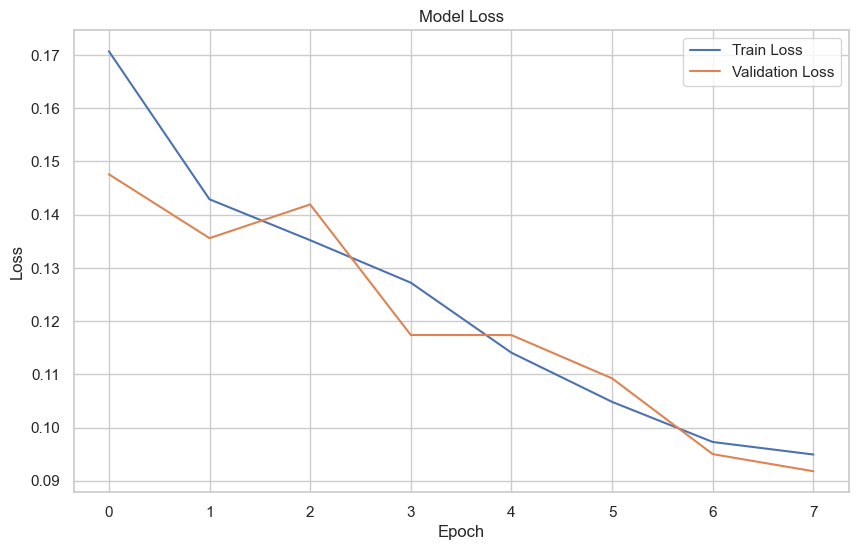

In [ ]:
df['Label'] = df['Label'].apply(lambda x: 1 if x == 'BENIGN' else 0).astype("int")  # BENIGN -> 1, non-BENIGN -> 0
df['Bwd Packet Length Max'] = df['Bwd Packet Length Max'].astype('int')

X = df.drop('Label', axis=1)
y = df['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = Sequential()
model.add(Dense(20, input_dim=X_train_scaled.shape[1], activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(
    X_train_scaled,
    y_train,
    epochs=8,
    batch_size=128,
    validation_data=(X_test_scaled, y_test)
)

loss, accuracy = model.evaluate(X_test_scaled, y_test)
print('Test accuracy: %.2f' % (accuracy*100))

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

### Find the best threshold

41757/41757 ━━━━━━━━━━━━━━━━━━━━ 21s 504us/step
Best Threshold: 0.76001001001001
Maximum Accuracy: 0.9632022774624613
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.93      0.92    321770
           1       0.98      0.97      0.98   1014454

    accuracy                           0.96   1336224
   macro avg       0.95      0.95      0.95   1336224
weighted avg       0.96      0.96      0.96   1336224



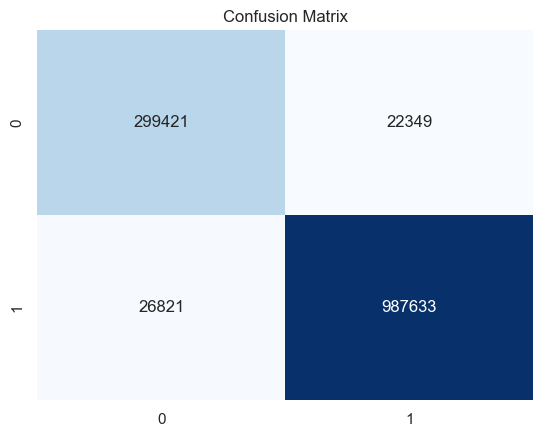

Accuracy Score:
0.9632022774624613


In [ ]:
df_big = pd.read_parquet('./IDS2017/Final/Combined.parquet')
df_big['Label'] = df_big['Label'].apply(lambda x: 1 if x == 'BENIGN' else 0).astype(int)  # BENIGN -> 1, non-BENIGN -> 0
df_big['Bwd Packet Length Max'] = df_big['Bwd Packet Length Max'].astype('int')
print(df_big['Label'].value_counts())

X_combined = df_big.drop('Label', axis=1)
y_combined = df_big['Label']
X_combined_scaled = scaler.transform(X_combined)

df_big['anomaly_score'] = model.predict(X_combined_scaled)

thresholds = np.linspace(0.75, 1, 1000)
max_accuracy = 0 
best_threshold = 0

for threshold in thresholds:
    df_big['anomaly'] = df_big['anomaly_score'].apply(lambda x: 0 if x < threshold else 1)
    accuracy = accuracy_score(y_combined, df_big['anomaly'])

    if accuracy > max_accuracy:
        max_accuracy = accuracy
        best_threshold = threshold


print("Best Threshold:", best_threshold)
print("Maximum Accuracy:", max_accuracy)

df_big['anomaly'] = df_big['anomaly_score'].apply(lambda x: 0 if x < best_threshold else 1)

print("Classification Report:")
print(classification_report(y_combined, df_big['anomaly']))

sns.heatmap(confusion_matrix(y_combined, df_big['anomaly']), fmt="d", annot=True, cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.show()

print("Accuracy Score:")
print(accuracy_score(y_combined, df_big['anomaly']))

#### Hard coded threshold

In [ ]:
X_combined = df_big.drop('Label', axis=1)
y_combined = df_big['Label']

scaler = StandardScaler()
scaler.fit(X_combined)

X_combined_scaled = scaler.transform(X_combined)

df_big['anomaly_score'] = model.predict(X_combined_scaled)

threshold = 0.7987987987987988

df_big['anomaly'] = df_big['anomaly_score'].apply(lambda x: 0 if x < threshold else 1)

print(df_big['anomaly'].value_counts())
print(df_big['anomaly_score'].min(), df_big['anomaly_score'].max())

print("Classification Report:")
print(classification_report(y_combined, df_big['anomaly']))

sns.heatmap(confusion_matrix(y_combined, df_big['anomaly']), fmt="d", annot=True, cmap='Blues', cbar=False)
plt.title('Macierz pomyłek')
plt.show()

print("Accuracy Score:")
print(accuracy_score(y_combined, df_big['anomaly']))

# Uczenie nienadzorowane

## Isolation Forest

Label
BENIGN              1014454
DoS Hulk             172846
DDoS                 128014
DoS GoldenEye         10286
DoS slowloris          5385
DoS Slowhttptest       5228
Heartbleed               11
Name: count, dtype: int64


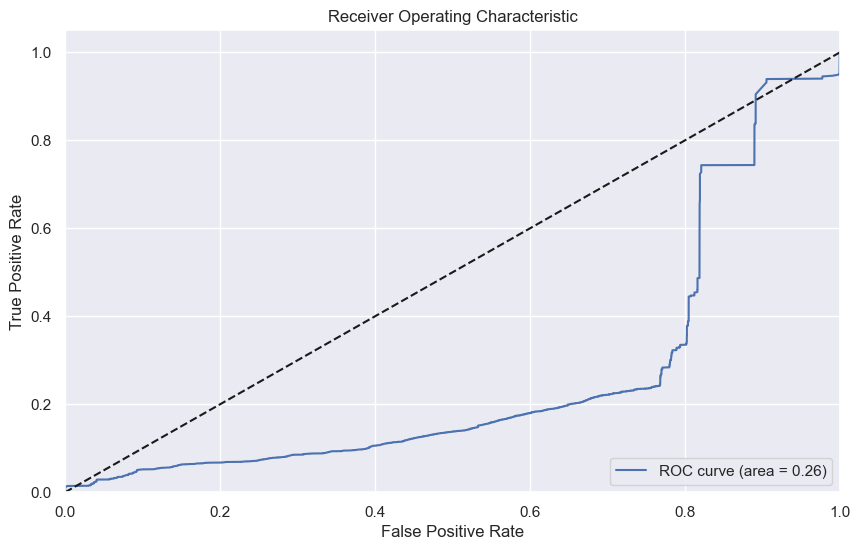

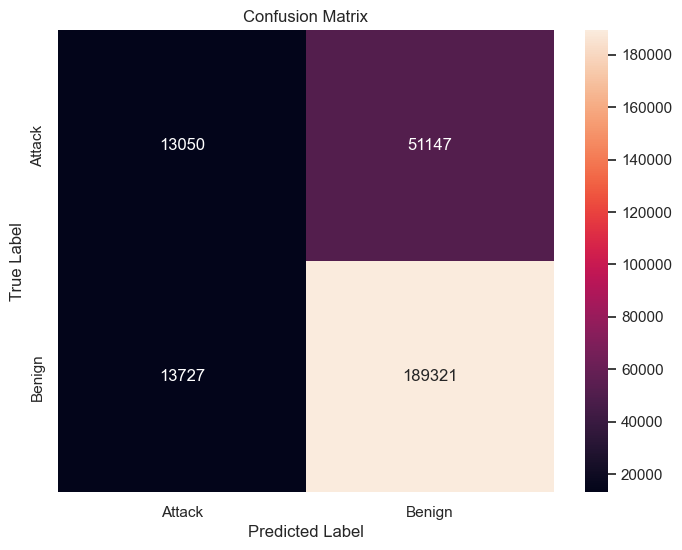

              precision    recall  f1-score   support

      Attack       0.49      0.20      0.29     64197
      Benign       0.79      0.93      0.85    203048

    accuracy                           0.76    267245
   macro avg       0.64      0.57      0.57    267245
weighted avg       0.72      0.76      0.72    267245



In [10]:
data = pd.read_parquet('IDS2017/Final/Combined.parquet')

print(data['Label'].value_counts())

y = data['Label']
y = y.apply(lambda x: 0 if x != 'BENIGN' else 1)  # 1 - benign, 0 - attack

X = data.drop('Label', axis=1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)  

iso_forest = IsolationForest(n_estimators=100, max_samples='auto', contamination=0.1, max_features=1.0, random_state=42)
iso_forest.fit(X_train)

y_score = -iso_forest.decision_function(X_test)

fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)


plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


y_pred = iso_forest.predict(X_test)
y_pred = np.where(y_pred == -1, 0, 1)


cm = confusion_matrix(y_test, y_pred)


labels = ['Attack', 'Benign']  
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cbar=True)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


print(classification_report(y_test, y_pred, target_names=labels))

## PCA

Read data

In [19]:
df = pd.read_parquet('./IDS2017/Final/Combined.parquet')
y = df['Label']
df = df.drop(columns=['Label'])
 
x = df.to_numpy()
col_mean = np.nanmean(x, axis=0)
inds = np.where(np.isnan(x))
x[inds] = np.take(col_mean, inds[1])
m = np.mean(x, 0)
s = np.std(x, 0)
x = (x-m)/s

In [12]:
u,s,vh = np.linalg.svd(x,full_matrices=False)
fi = vh.T
z = u@np.diag(s)

<Axes: xlabel='0', ylabel='1'>

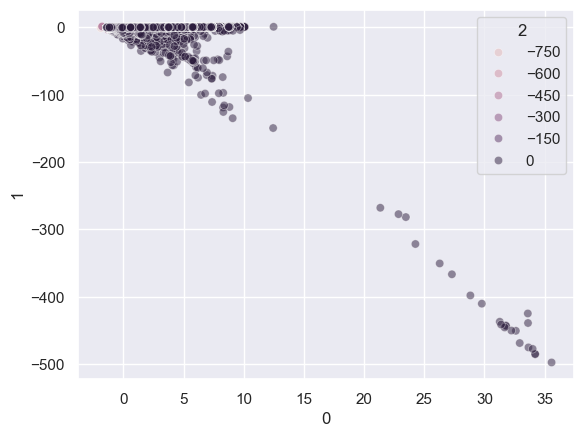

In [13]:
sns.scatterplot(
    data= pd.DataFrame(z),
    x=0,
    y=1,
    hue=2,
    alpha=0.5
)

<Axes: xlabel='0', ylabel='1'>

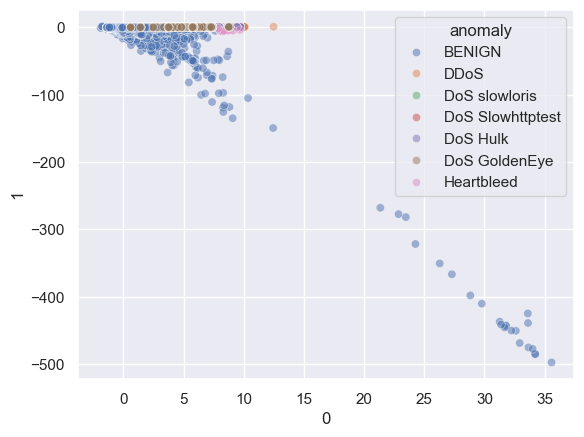

In [21]:
df = pd.DataFrame(z)

df['anomaly'] = y

sns.scatterplot(
    data=df,
    x=0,
    y=1,
    hue='anomaly',
    alpha=0.5
)

## Autoencoder

In [33]:
df = pd.read_parquet('./IDS2017/Final/Combined.parquet')
y = df['Label']
df = df.drop(columns=['Label'])
x = df.to_numpy()
y = y.apply(lambda x: 0 if x != 'BENIGN' else 1)  # 1 - benign, 0 - attack
y = y.to_numpy()



def vector_mse(y,yhat):
    return jnp.mean(jnp.square(y-yhat), axis=-1)

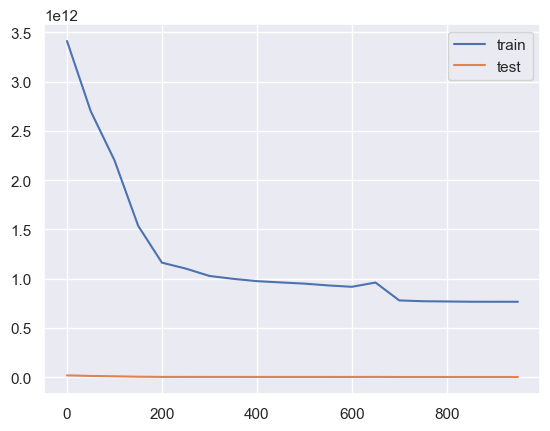

In [29]:
batch_size = 128
steps = 1000 
learning_rate = 0.001
train_split = int(0.7*x.shape[0])

k = jax.random.PRNGKey(42)

encoder = stax.serial(
    stax.Dense(16),
    stax.Relu,
    stax.Dense(8)
)

decoder = stax.serial(
    stax.Dense(16),
    stax.Relu,
    stax.Dense(x.shape[1])
)

nn = stax.serial(encoder, decoder)

init_nn, apply_nn = nn
opt_init, opt_update, get_params = adam(learning_rate)



@jax.jit 
def step(i, opt_state, x,y):
  params = get_params(opt_state)

  def loss(params,x,y):
      reconstruction = apply_nn(params,x) 
      return jnp.mean(vector_mse(y,reconstruction))

  g = jax.grad(loss)(params, x,y) 
  opt_state = opt_update(i, g, opt_state)
  step_loss = loss(get_params(opt_state),x,y)
  return opt_state, step_loss

@jax.jit
def test_loss(opt_state,x,y):
    params = get_params(opt_state) 
    reconstruction = apply_nn(params,x) 
    return jnp.mean(vector_mse(y,reconstruction))

_,params  = init_nn(k,(batch_size,x.shape[1])) 
opt_state = opt_init(params)

losses = []
test_losses = []
train_steps = []

for i in range(steps):
    idx = np.random.randint(0, train_split, size=batch_size)
    bx = x[idx,...]

    opt_state, step_loss = step(i, opt_state,bx,bx) 

    if i % 50 == 0:
        tx = x[train_split:,...]
        test_losses.append(test_loss(opt_state,tx,tx))
        train_steps.append(i) 
        losses.append(test_loss(opt_state,x[:train_split,...],x[:train_split,...]))

plt.plot(train_steps,losses,label='train')
plt.plot(train_steps,test_losses,label='test')
 
plt.legend()

              precision    recall  f1-score   support

           0       0.24      0.96      0.39    321770
           1       0.80      0.05      0.09   1014454

    accuracy                           0.27   1336224
   macro avg       0.52      0.51      0.24   1336224
weighted avg       0.67      0.27      0.16   1336224



Text(0.5, 20.049999999999997, 'Predicted Label')

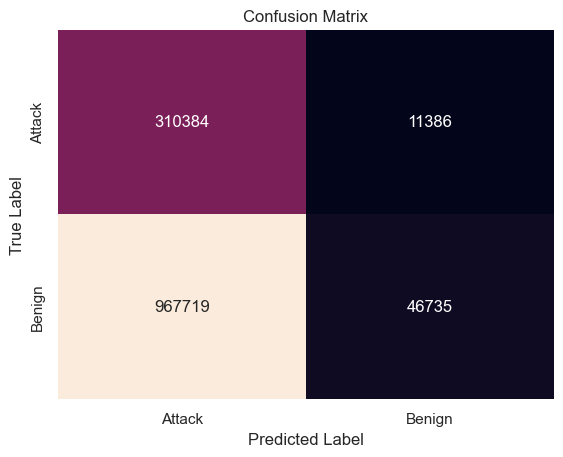

In [35]:

reconstruction = apply_nn(get_params(opt_state), x)
reconstruction_error = np.mean(np.square(x - reconstruction), axis=1)

threshold = np.percentile(reconstruction_error[:train_split], 95)  # e.g., 95th percentile

y_pred = (reconstruction_error > threshold).astype(int)

print(classification_report(y, y_pred))

cm = confusion_matrix(y, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Attack', 'Benign'], yticklabels=['Attack', 'Benign'], cbar=False)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')



## K-Means

In [ ]:
df = pd.read_parquet('./IDS2017/Final/DDoS_Attacks.parquet')
print(df.columns)

features = df[[' Destination Port', 'Total Length of Fwd Packets',
       ' Fwd Packet Length Max', ' Fwd Packet Length Mean',
       ' Fwd Header Length', ' Avg Fwd Segment Size', ' Subflow Fwd Bytes',
       'Init_Win_bytes_forward', ' act_data_pkt_fwd']]

Index([' Label', ' Destination Port', 'Total Length of Fwd Packets',
       ' Fwd Packet Length Max', ' Fwd Packet Length Mean',
       ' Fwd Header Length', ' Avg Fwd Segment Size', ' Subflow Fwd Bytes',
       'Init_Win_bytes_forward', ' act_data_pkt_fwd'],
      dtype='object')


In [ ]:
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(features)

df['Cluster'] = kmeans.labels_

print(df.head())

    Label   Destination Port  Total Length of Fwd Packets  \
0  BENIGN              54865                           12   
1  BENIGN              55054                            6   
2  BENIGN              55055                            6   
3  BENIGN              46236                            6   
4  BENIGN              54863                           12   

    Fwd Packet Length Max   Fwd Packet Length Mean   Fwd Header Length  \
0                       6                      6.0                  40   
1                       6                      6.0                  20   
2                       6                      6.0                  20   
3                       6                      6.0                  20   
4                       6                      6.0                  40   

    Avg Fwd Segment Size   Subflow Fwd Bytes  Init_Win_bytes_forward  \
0                    6.0                  12                      33   
1                    6.0                   6

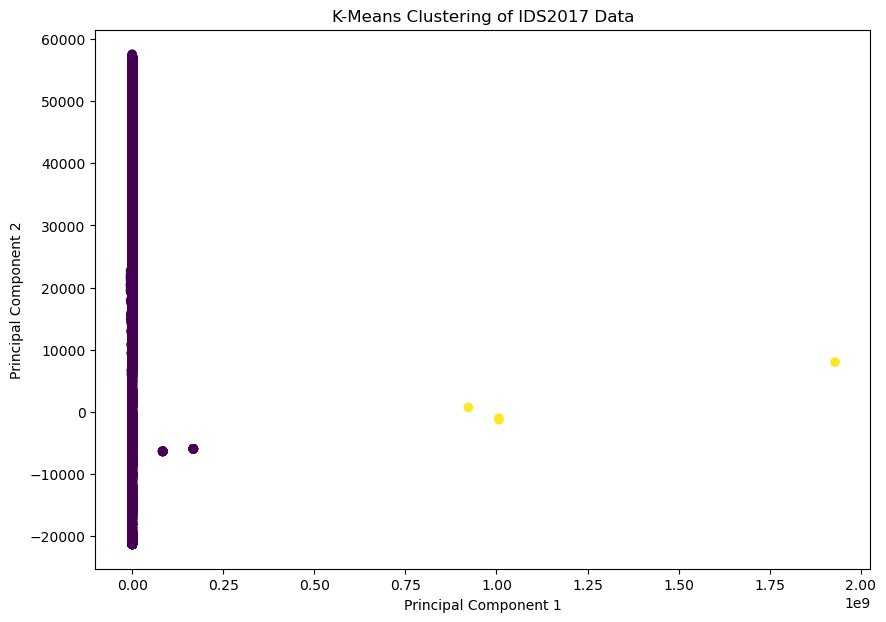

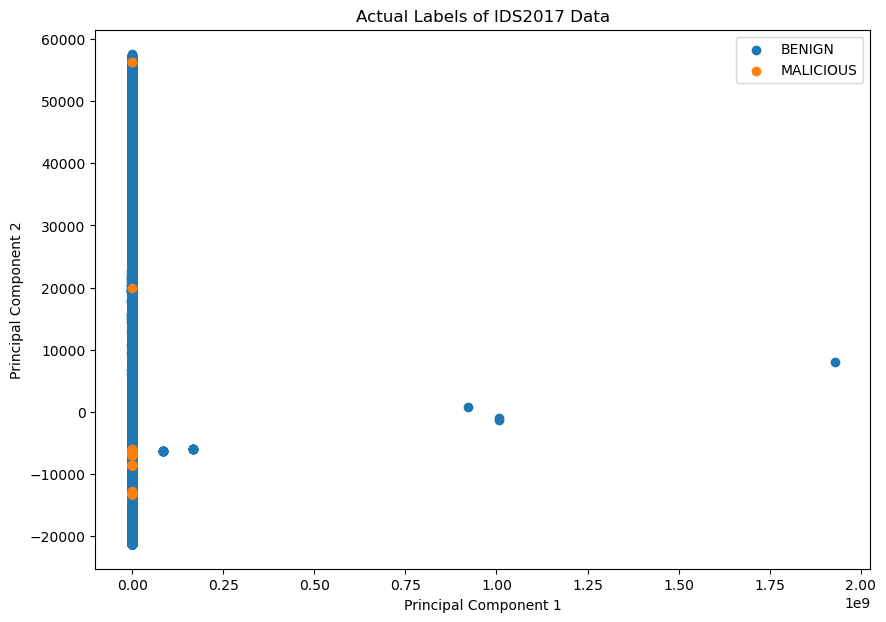

In [ ]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(features)
df_pca = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])
df_pca['Cluster'] = kmeans.labels_
df_pca[' Label'] = df[' Label']

plt.figure(figsize=(10, 7))
plt.scatter(df_pca['PC1'], df_pca['PC2'], c=df_pca['Cluster'])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-Means Clustering of IDS2017 Data')
plt.show()

plt.figure(figsize=(10, 7))
plt.scatter(df_pca[df_pca[' Label'] == 'BENIGN']['PC1'], df_pca[df_pca[' Label'] == 'BENIGN']['PC2'], label='BENIGN')
plt.scatter(df_pca[df_pca[' Label'] != 'BENIGN']['PC1'], df_pca[df_pca[' Label'] != 'BENIGN']['PC2'], label='MALICIOUS')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Actual Labels of IDS2017 Data')
plt.legend()
plt.show()